In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, json, re
import itertools, argparse, pickle, random

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, sampler

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Loading data, preprocessing and batchifying

### Download data

In [0]:
path = '/content/data'
if not os.path.exists(path): os.mkdir(path)
os.chdir(path)

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [0]:
!kaggle competitions download -c quora-insincere-questions-classification -f train.csv

 90% 49.0M/54.4M [00:00<00:00, 52.2MB/s]
100% 54.4M/54.4M [00:00<00:00, 85.7MB/s]


In [0]:
!kaggle competitions download -c quora-insincere-questions-classification -f test.csv

 57% 9.00M/15.7M [00:00<00:00, 61.3MB/s]
100% 15.7M/15.7M [00:00<00:00, 76.7MB/s]


In [0]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

### Loading and preprocessing

In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_punc(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

misspell_dict = {"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"}


# def clean_text(raw, correct=False):
#     text = re.sub(r'[^\w\s\'\*]+', '', raw.strip())
#     misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
#     def replace(match):
#         return misspell_dict[match.group(0)]
#     return misspell_re.sub(replace, text) if correct else text
def replace_typical_misspell(text):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    def replace(match):
        return misspell_dict[match.group(0)]
    return misspell_re.sub(replace, text)


def clean_text(raw):
    return clean_numbers(clean_punc(replace_typical_misspell(raw.lower())))


def word_idx_map(raw_questions, vocab_size):
    texts = []
    for q in raw_questions:
        texts.append(q.split())
    word_freq = nltk.FreqDist(itertools.chain(*texts))
    vocab_freq = word_freq.most_common(vocab_size-2)
    idx_to_word = ['<pad>'] + [word for word, cnt in vocab_freq] + ['<unk>']
    word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

    return idx_to_word, word_to_idx


def tokenize(questions, word_to_idx, maxlen):
    '''
    Tokenize and numerize the question sequences
    Inputs:
    - questions: pandas series with quora questions
    - word_to_idx: mapping from word to index
    - maxlen: max length of each sequence of tokens

    Returns:
    - tokens: array of shape (data_size, maxlen)
    '''

    tokens = []
    for q in tqdm(questions.tolist()):
        token = [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                 for w in q.split()]
        if len(token) > maxlen:
            token = token[-maxlen:]
        else:
            token = [0] * (maxlen-len(token)) + token
        tokens.append(token)
    return np.array(tokens).astype('int32')

In [0]:
%%time
train_df = pd.read_csv(os.path.join(path,'train.csv'))
test_df = pd.read_csv(os.path.join(path,'test.csv'))

CPU times: user 3.39 s, sys: 271 ms, total: 3.66 s
Wall time: 3.66 s


In [0]:
%%time
tqdm.pandas()
train_df['question_text'] = train_df['question_text'].progress_apply(clean_text)
test_df['question_text'] = test_df['question_text'].progress_apply(clean_text)


CPU times: user 1min 52s, sys: 1.06 s, total: 1min 53s
Wall time: 1min 54s


In [0]:
%%time
vocab_size = 120000

train_tar = train_df['target'].values.astype('int32')
idx_to_word, word_to_idx = word_idx_map(train_df['question_text'], vocab_size)
train_seq = tokenize(train_df['question_text'], word_to_idx, 40)
x_test = tokenize(test_df['question_text'], word_to_idx, 40)


CPU times: user 51.3 s, sys: 973 ms, total: 52.2 s
Wall time: 52.3 s


### train/val split

In [0]:
train_seq.shape, train_tar.shape, x_test.shape, len(word_to_idx)

((1306122, 40), (1306122,), (375806, 40), 120000)

In [0]:
train_tar.sum() / len(train_tar)

0.06187017751787352

In [0]:
np.random.seed(2019)
mask = np.random.rand(len(train_seq)) < 0.8
x_val = train_seq[~mask]
x_train = train_seq[mask]
y_val = train_tar[~mask]
y_train = train_tar[mask]

In [0]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1045342, 40), (1045342,), (260780, 40), (260780,))

In [0]:
y_train.sum() / len(y_train), y_val.sum() / len(y_val)

(0.062104076943239626, 0.060932586854820156)

### data loader

In [0]:
class Quora_sincerity(Dataset):

    def __init__(self, tokenized_questions, targets=None):
        self.questions = tokenized_questions
        self.targets = targets[:,None] if targets is not None else targets

    def __getitem__(self, index):
        question = self.questions[index]
        if self.targets is not None:
            target = self.targets[index]
            return torch.LongTensor(question), torch.FloatTensor(target)
        else:
            return torch.LongTensor(question)

    def __len__(self):
        return len(self.questions)


def prepare_loader(x, y=None, batch_size=1024, train=True):
    data_set = Quora_sincerity(x, y)
    if train:
        return DataLoader(data_set, batch_size=batch_size, shuffle=True)
    else:
        return DataLoader(data_set, batch_size=batch_size)

In [0]:
train_loader = prepare_loader(x_train, y_train, 32)
x_b, y_b = next(iter(train_loader))
x_b.shape, y_b.shape

(torch.Size([32, 40]), torch.Size([32, 1]))

## Load embeddings

In [0]:
# Load pre-trained word vector
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding(embedding_file, embedding_dim, word_to_idx, vocab_size):
    with open(embedding_file, encoding="utf8", errors='ignore') as f:
        embeddings_index = dict(get_coefs(*o.split(' ')) for o in tqdm(f) if len(o)>100)
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    nb_words = min(vocab_size, len(word_to_idx))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
    for word, i in tqdm(word_to_idx.items()):
        if i >= vocab_size: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
os.chdir('/content/drive/My Drive/DL_projects/quora_toxic')
os.listdir('../Data/wordvecs')

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M']

In [0]:
%%time
EMBEDDING_FILE_GV = '../Data/wordvecs/glove.840B.300d/glove.840B.300d.txt'
EMBEDDING_FILE_PR = '../Data/wordvecs/paragram_300_sl999/paragram_300_sl999.txt'
EMBEDDING_FILE_FT = '../Data/wordvecs/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embed_mat_1 = get_embedding(EMBEDDING_FILE_GV, 300, word_to_idx, vocab_size)
embed_mat_2 = get_embedding(EMBEDDING_FILE_PR, 300, word_to_idx, vocab_size)
#embed_mat_3 = get_embedding(EMBEDDING_FILE_FT, 300, word_to_idx, vocab_size)
embed_mat = np.mean([embed_mat_1, embed_mat_2], 0)


CPU times: user 6min 30s, sys: 38.2 s, total: 7min 8s
Wall time: 8min 2s


In [0]:
%%time
EMBEDDING_FILE = '../Data/wordvecs/glove.840B.300d/glove.840B.300d.txt'
embed_mat = get_embedding(EMBEDDING_FILE, 300, word_to_idx, vocab_size)


CPU times: user 3min 31s, sys: 23.2 s, total: 3min 55s
Wall time: 4min 28s


In [0]:
embed_mat.shape

(120000, 300)

In [0]:
# find number of OOVs from each embedding (glove, para, fasttext)
# 17361, 59699, 22107 OOVs for each
c = 0
for w, i in word_to_idx.items():
    vec = embed_mat.get(w)
    if vec is None: c += 1

## Model

In [0]:
class Attention(nn.Module):
    def __init__(self, feature_dim, **kwargs):
        super(Attention, self).__init__(**kwargs)

        self.feature_dim = feature_dim
        self.proj_to_alpha = nn.Linear(feature_dim, 1)

        nn.init.xavier_uniform_(self.proj_to_alpha.weight)
        self.proj_to_alpha.bias.data.fill_(0.)

    def forward(self, seq):   # seq: (N, T, D)
        mid = F.relu(seq)   # (N, T, D)
        eij = self.proj_to_alpha(mid).squeeze()   # (N, T)
        alpha = F.softmax(eij, dim=-1)   # (N, T)
        context = torch.sum(alpha.unsqueeze(-1) * seq, 1)   # (N, D)

        return context, alpha


class QIQCNet(nn.Module):

    def __init__(self, embed_dim, hidden_dim, vocab_size, embed_matrix):
        super(QIQCNet, self).__init__()
        # Record the arguments
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        # Init layers
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.dropout_seq = nn.Dropout2d(0.25)
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)
#         self.lstm_attention = Attention(hidden_dim*2)
#         self.gru_attention = Attention(hidden_dim*2)
        
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_dim*4, 1)

        # Weight initialization
        self.emb.weight = nn.Parameter(torch.tensor(embed_matrix, dtype=torch.float32))
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            if 'weight_hh' in name:
                nn.init.orthogonal_(param)

        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            if 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def forward(self, seq):
        emb = self.emb(seq)
        emb = self.dropout_seq(emb.transpose(1,2).unsqueeze(-1)).squeeze().transpose(1,2)
        o_lstm, _ = self.lstm(emb)
        o_gru, _ = self.gru(o_lstm)
#         o_lstm_atten, _ = self.lstm_attention(o_lstm)
#         o_gru_atten, _ = self.gru_attention(o_gru)

        # pooling
        avg_pool = torch.mean(o_gru, 1)
        max_pool, _ = torch.max(o_gru, 1)
        x = torch.cat((avg_pool, max_pool), 1)
        out = self.out(self.dropout(x))

        return out

In [0]:
def model_test():
    x = torch.zeros((64, 40), dtype=torch.long)
    x = x.to(device=device)
    
    model = QIQCNet(300, 48, vocab_size, embed_mat)
    model = model.to(device=device)
    scores = model(x)
    print(scores.size())

model_test()

torch.Size([64, 1])


## Training the model

### solver for training

In [0]:
output_path = './'

# evaluation metric
# def f1_threshold(y_true, preds):
#     precision, recall, thresholds = precision_recall_curve(y_true, preds)
#     thresholds = np.append(thresholds, 1.001)
#     f1 = 2*precision*recall / (precision + recall)
#     best_f1 = f1.max()
#     threshold = thresholds[np.argmax(f1)]
#     return best_f1, threshold
def f1_threshold(y_true, preds):
    best_f1 = 0
    for i in np.arange(0.1, 0.51, 0.01):
        f1 = f1_score(y_true, preds > i)
        if f1 > best_f1:
            threshold = i
            best_f1 = f1
    return best_f1, threshold


# solver of model with validation
class NetSolver(object):

    def __init__(self, model, **kwargs):
        self.model = model

        # hyperparameters
        self.lr_init = kwargs.pop('lr_init', 0.001)
        self.lr_decay = kwargs.pop('lr_decay', 0.1)
        self.step_size = kwargs.pop('step_size', 10)
        self.print_every = kwargs.pop('print_every', 2000)
        self.checkpoint_name = kwargs.pop('checkpoint_name', 'qiqc')

        # setup optimizer
        self.optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()),
                                    lr=self.lr_init)
        #self.optimizer = optim.SGD(filter(lambda p: p.requires_grad, self.model.parameters()),
        #                           lr=self.lr_init, momentum=0.9)
        #self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.lr_decay)
        #self.scheduler = ReduceLROnPlateau(self.optimizer, factor=self.lr_decay, patience=10)

        self.model = self.model.to(device=device)
        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization. Don't call this
        manually.
        """
        self.best_val_loss = 0.
        self.best_val_f1 = 0.
        self.loss_history = []
        self.val_loss_history = []
        self.f1_history = []
        self.val_f1_history = []

    def _save_checkpoint(self, epoch, l_val, f_val):
        torch.save(self.model.state_dict(),
            output_path+self.checkpoint_name+'_%.3f_%.3f_epoch_%d.pth.tar' %(l_val, f_val, epoch))
        checkpoint = {
            'optimizer': str(type(self.optimizer)),
            'scheduler': str(type(self.scheduler)),
            'lr_init': self.lr_init,
            'lr_decay': self.lr_decay,
            'step_size': self.step_size,
            'epoch': epoch,
        }
        with open(output_path+'hyper_param_optim.json', 'w') as f:
            json.dump(checkpoint, f)


    def forward_pass(self, x, y):
        x = x.to(device=device, dtype=torch.long)
        y = y.to(device=device, dtype=dtype)
        scores = self.model(x)
        loss = F.binary_cross_entropy_with_logits(scores, y)
        return loss, torch.sigmoid(scores)


    def lr_range_test(self, train_loader, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        epochs = int(np.ceil(num_it/len(train_loader)))

        lrs_log, loss_log = [], []
        n, curr_lr = 0, start_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = curr_lr

        for e in range(epochs):
            self.model.train()
            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                lrs_log.append(curr_lr)
                loss_log.append(loss.item())

                # update best loss
                if n == 0:
                    best_loss, n_best = loss.item(), n
                else:
                    if loss.item() < best_loss:
                        best_loss, n_best = loss.item(), n

                # update lr per iter
                n += 1
                curr_lr = start_lr * (end_lr/start_lr) ** (n/num_it)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = curr_lr

                # stopping condition
                if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                    break

        print('minimum loss {}, at lr {}'.format(best_loss, lrs_log[n_best]))
        return lrs_log, loss_log
    
    
    def train(self, loaders, epochs):
        train_loader, val_loader = loaders

        # start training for epochs
        for e in range(epochs):
            self.model.train()
            print('\nEpoch %d / %d:' % (e + 1, epochs))
            #self.scheduler.step()
            running_loss = 0.

            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * x.size(0)

            N = len(train_loader.dataset)
            train_loss = running_loss / N
            print('For train set,')
            train_f1, train_thres, _ = self.check_f1(train_loader, num_batches=50)
            print('For val set,')
            val_f1, val_thres, val_loss = self.check_f1(val_loader, save_scores=True)
            #self.scheduler.step(val_loss)
            
            self.log_and_checkpoint(e, train_loss, val_loss, train_f1, val_f1)
            
            
    def train_one_cycle(self, loaders, epochs, max_lr, moms=(.95, .85), div_factor=25, sep_ratio=0.3):
        train_loader, val_loader = loaders

        # one-cycle setup
        tot_it = epochs * len(train_loader)
        up_it = int(tot_it * sep_ratio)
        down_it = tot_it - up_it
        min_lr = max_lr / div_factor
        n, curr_lr, curr_mom = 0, min_lr, moms[0]
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = curr_lr
            param_group['betas'] = (curr_mom, 0.999)

        # start training for epochs
        for e in range(epochs):
            self.model.train()
            print('\nEpoch %d / %d:' % (e + 1, epochs))
            running_loss = 0.

            for x, y in tqdm(train_loader):
                loss, _ = self.forward_pass(x, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * x.size(0)

                # update lr, mom per iter
                n += 1
                if n <= up_it:
                    curr_lr = max_lr + (min_lr - max_lr)/2 * (np.cos(np.pi*n/up_it)+1)
                    curr_mom = moms[1] + (moms[0] - moms[1])/2 * (np.cos(np.pi*n/up_it)+1)
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = curr_lr
                        param_group['betas'] = (curr_mom, 0.999)
                else:
                    curr_lr = min_lr + (max_lr - min_lr)/2 * (np.cos(np.pi*(n-up_it)/down_it)+1)
                    curr_mom = moms[0] + (moms[1] - moms[0])/2 * (np.cos(np.pi*(n-up_it)/down_it)+1)
                    for param_group in self.optimizer.param_groups:
                        param_group['lr'] = curr_lr
                        param_group['betas'] = (curr_mom, 0.999)

            N = len(train_loader.dataset)
            train_loss = running_loss / N
            print('For train set,')
            train_f1, train_thres, _ = self.check_f1(train_loader, num_batches=50)
            print('For val set,')
            val_f1, val_thres, val_loss = self.check_f1(val_loader, save_scores=True)

            self.log_and_checkpoint(e, train_loss, val_loss, train_f1, val_f1)
    
    
    def log_and_checkpoint(self, e, train_loss, val_loss, train_f1, val_f1):
        # checkpoint and record/print metrics at epoch end
        self.loss_history.append(train_loss)
        self.val_loss_history.append(val_loss)
        self.f1_history.append(train_f1)
        self.val_f1_history.append(val_f1)

        # for floydhub metric graphs
        print('{"metric": "F1", "value": %.4f, "epoch": %d}' % (train_f1, e+1))
        print('{"metric": "Val. F1", "value": %.4f, "epoch": %d}' % (val_f1, e+1))
        print('{"metric": "Loss", "value": %.4f, "epoch": %d}' % (train_loss, e+1))
        print('{"metric": "Val. Loss", "value": %.4f, "epoch": %d}' % (val_loss, e+1))

        #is_updated = False
        if e == 0:
            self.best_val_f1 = val_f1
            self.best_val_loss = val_loss
        if val_f1 > self.best_val_f1:
            print('updating best val f1...')
            self.best_val_f1 = val_f1
            #is_updated = True
        if val_loss < self.best_val_loss:
            print('updating best val loss...')
            self.best_val_loss = val_loss
            #is_updated = True
#         if e > 1 and is_updated:
#             print('Saving model...')
#             self._save_checkpoint(e+1, val_loss, val_f1)
        print()


    def check_f1(self, loader, num_batches=None, save_scores=False):
        self.model.eval()
        targets, scores, losses = [], [], []
        with torch.no_grad():
            for t, (x, y) in enumerate(loader):
                l, score = self.forward_pass(x, y)
                targets.append(y.cpu().numpy())
                scores.append(score.cpu().numpy())
                losses.append(l.item())
                if num_batches is not None and (t+1) == num_batches:
                    break
        
        targets = np.concatenate(targets)
        scores = np.concatenate(scores)
        if save_scores:
            self.val_scores = scores  # to access from outside
        
        best_f1, threshold = f1_threshold(targets, scores)
        loss = np.mean(losses)
        print('Best threshold is {:.4f}, with F1 score: {:.4f}'.format(threshold, best_f1))
        
        return best_f1, threshold, loss

In [0]:
train_loader = prepare_loader(x_train, y_train, 512)
val_loader = prepare_loader(x_val, y_val, train=False)
test_loader = prepare_loader(x_test, train=False)

In [0]:
model = QIQCNet(300, 192, vocab_size, embed_mat)
for name, param in model.named_parameters():
    if 'emb' in name:
        param.requires_grad = False
solver = NetSolver(model)

### Learning rate range test

In [0]:
%%time
lrs_log, loss_log = solver.lr_range_test(train_loader)

minimum loss 0.16308775544166565, at lr 0.0008317637711026709
CPU times: user 6.25 s, sys: 3.63 s, total: 9.87 s
Wall time: 10.1 s


Text(0, 0.5, 'Learning rate')

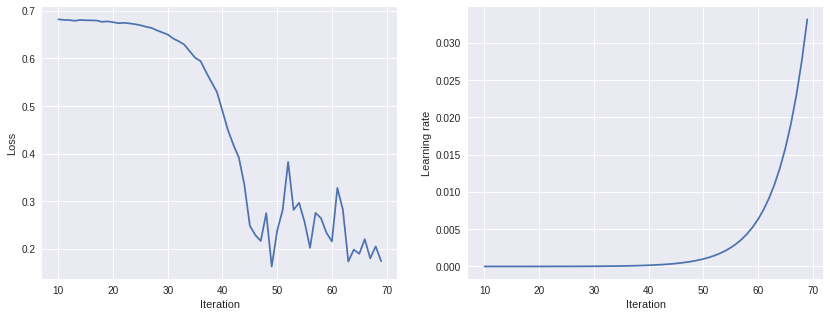

In [0]:
iters = range(len(lrs_log))
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(iters[10:-5], loss_log[10:-5])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(iters[10:-5], lrs_log[10:-5])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Learning rate')

Text(0, 0.5, 'Loss')

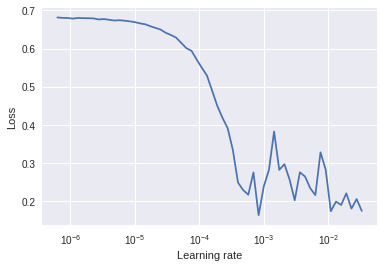

In [0]:
plt.plot(lrs_log[10:-5], loss_log[10:-5])
plt.xscale('log')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

After the range test, we need to re-initialize the model.

In [0]:
model = QIQCNet(300, 192, vocab_size, embed_mat)
for name, param in model.named_parameters():
    if 'emb' in name:
        param.requires_grad = False
solver = NetSolver(model)

### Train in one cycle policy

In [0]:
%%time
solver.train_one_cycle(loaders=(train_loader, val_loader), epochs=5, max_lr=5e-4)


Epoch 1 / 5:


For train set,
Best threshold is 0.3400, with F1 score: 0.6220
For val set,
Best threshold is 0.3500, with F1 score: 0.6094
{"metric": "F1", "value": 0.6220, "epoch": 1}
{"metric": "Val. F1", "value": 0.6094, "epoch": 1}
{"metric": "Loss", "value": 0.1675, "epoch": 1}
{"metric": "Val. Loss", "value": 0.1161, "epoch": 1}


Epoch 2 / 5:


For train set,
Best threshold is 0.4200, with F1 score: 0.6804
For val set,
Best threshold is 0.3900, with F1 score: 0.6538
{"metric": "F1", "value": 0.6804, "epoch": 2}
{"metric": "Val. F1", "value": 0.6538, "epoch": 2}
{"metric": "Loss", "value": 0.1134, "epoch": 2}
{"metric": "Val. Loss", "value": 0.1070, "epoch": 2}
updating best val f1...
updating best val loss...


Epoch 3 / 5:


For train set,
Best threshold is 0.4000, with F1 score: 0.7037
For val set,
Best threshold is 0.4500, with F1 score: 0.6730
{"metric": "F1", "value": 0.7037, "epoch": 3}
{"metric": "Val. F1", "value": 0.6730, "epoch": 3}
{"metric": "Loss", "value": 0.1041, "epoch": 3}
{"metric": "Val. Loss", "value": 0.1017, "epoch": 3}
updating best val f1...
updating best val loss...


Epoch 4 / 5:


For train set,
Best threshold is 0.4300, with F1 score: 0.6985
For val set,
Best threshold is 0.4200, with F1 score: 0.6805
{"metric": "F1", "value": 0.6985, "epoch": 4}
{"metric": "Val. F1", "value": 0.6805, "epoch": 4}
{"metric": "Loss", "value": 0.0986, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0984, "epoch": 4}
updating best val f1...
updating best val loss...


Epoch 5 / 5:


For train set,
Best threshold is 0.3400, with F1 score: 0.7205
For val set,
Best threshold is 0.3300, with F1 score: 0.6837
{"metric": "F1", "value": 0.7205, "epoch": 5}
{"metric": "Val. F1", "value": 0.6837, "epoch": 5}
{"metric": "Loss", "value": 0.0947, "epoch": 5}
{"metric": "Val. Loss", "value": 0.0967, "epoch": 5}
updating best val f1...
updating best val loss...

CPU times: user 14min 59s, sys: 8min 58s, total: 23min 58s
Wall time: 24min 32s


In [0]:
%%time
solver.train_one_cycle(loaders=(train_loader, val_loader), epochs=4, max_lr=1e-3)


Epoch 1 / 4:


For train set,
Best threshold is 0.2800, with F1 score: 0.6440
For val set,
Best threshold is 0.2900, with F1 score: 0.6376
{"metric": "F1", "value": 0.6440, "epoch": 1}
{"metric": "Val. F1", "value": 0.6376, "epoch": 1}
{"metric": "Loss", "value": 0.1477, "epoch": 1}
{"metric": "Val. Loss", "value": 0.1096, "epoch": 1}


Epoch 2 / 4:


For train set,
Best threshold is 0.2800, with F1 score: 0.6794
For val set,
Best threshold is 0.3600, with F1 score: 0.6709
{"metric": "F1", "value": 0.6794, "epoch": 2}
{"metric": "Val. F1", "value": 0.6709, "epoch": 2}
{"metric": "Loss", "value": 0.1074, "epoch": 2}
{"metric": "Val. Loss", "value": 0.1003, "epoch": 2}
updating best val f1...
updating best val loss...


Epoch 3 / 4:


For train set,
Best threshold is 0.3400, with F1 score: 0.7173
For val set,
Best threshold is 0.3300, with F1 score: 0.6823
{"metric": "F1", "value": 0.7173, "epoch": 3}
{"metric": "Val. F1", "value": 0.6823, "epoch": 3}
{"metric": "Loss", "value": 0.0987, "epoch": 3}
{"metric": "Val. Loss", "value": 0.0965, "epoch": 3}
updating best val f1...
updating best val loss...


Epoch 4 / 4:


For train set,
Best threshold is 0.4600, with F1 score: 0.7236
For val set,
Best threshold is 0.3500, with F1 score: 0.6850
{"metric": "F1", "value": 0.7236, "epoch": 4}
{"metric": "Val. F1", "value": 0.6850, "epoch": 4}
{"metric": "Loss", "value": 0.0918, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0961, "epoch": 4}
updating best val f1...
updating best val loss...

CPU times: user 11min 52s, sys: 7min 10s, total: 19min 3s
Wall time: 19min 30s


### visualization

In [0]:
model.load_state_dict(torch.load('qiqc_model.pth'))

In [0]:
def extract_features(x, net):
    x = x.to(device)
    net.to(device)
    features = []
    modules = [m for m in net.children()]
    features.append(modules[0](x))
    features.append(modules[1](features[-1].transpose(1,2).unsqueeze(-1)).squeeze().transpose(0,1).unsqueeze(0))
    features.append(modules[2](features[-1])[0])
    features.append(modules[3](features[-1])[0])
    return [f.cpu().detach().numpy() for f in features]


def normalize_cam(cam):
    cam = cam - np.min(cam)
    return cam / np.max(cam)


def return_cam(features, weights):
    # generate the class activation maps (CAMs) upsample to 256x256
    D = len(weights)
    cam_avg = weights[:int(D/2)].dot(features.T)
    cam_avg = normalize_cam(cam_avg)
    cam_max = weights[int(D/2):].dot(features.T)
    cam_max = normalize_cam(cam_max)
    return cam_avg, cam_max


def plot_cam(x, y):
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2., 0, 1]
    ax1.imshow(y[None,:], cmap="hot", aspect="auto", extent=extent)
    ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)

    plt.tight_layout()
    plt.show()

In [0]:
# val samples
xs, ys = next(iter(val_loader))
xs, ys = xs.numpy(), ys.numpy()

In [0]:
# samples with positive label
np.where(ys==1)[0]

array([   8,   25,   47,   70,   88,  123,  192,  196,  204,  219,  230,
        253,  258,  262,  281,  287,  312,  323,  345,  349,  350,  364,
        374,  391,  413,  437,  442,  451,  464,  468,  474,  475,  497,
        498,  505,  526,  539,  549,  555,  577,  602,  611,  629,  630,
        633,  639,  646,  665,  681,  694,  702,  722,  745,  761,  777,
        783,  791,  792,  809,  817,  833,  868,  882,  898,  906,  919,
        930,  942,  981, 1005, 1010, 1011])

In [0]:
final_weights = list(model.parameters())[-2].cpu().detach().numpy()   # (1, 4*H)
features = extract_features(torch.tensor(xs[5]).unsqueeze(0), model)
features_rnn = features[-1]   # (1, T, 2*H)
cam_1, cam_2 = return_cam(np.squeeze(features_rnn), np.squeeze(final_weights))

what do you know about bram fischer and the rivonia trial ?
with label 0.0
with prediction prob. 0.0018302309326827526


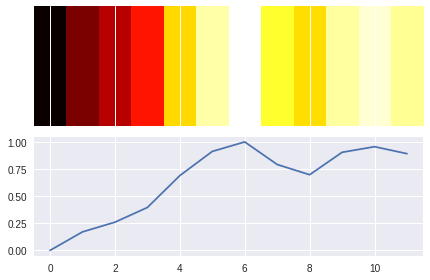

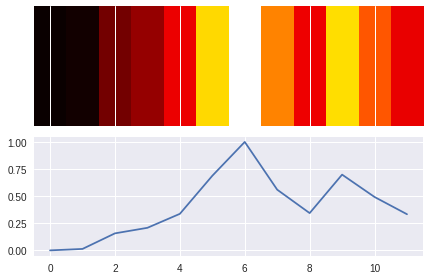

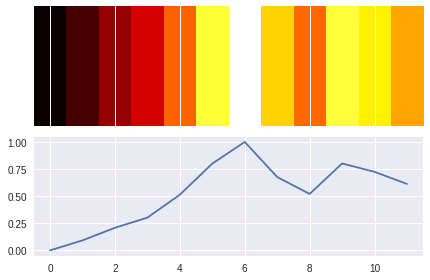

In [0]:
seq_len = len(xs[5][xs[5]>0])
cam_1 = normalize_cam(cam_1[-seq_len:])
cam_2 = normalize_cam(cam_2[-seq_len:])

print(' '.join([idx_to_word[idx] for idx in xs[5][xs[5]>0]]))
print(f'with label {ys[5].item()}')
print(f'with prediction prob. {torch.sigmoid(model(torch.tensor(xs[5:7]).cuda())).cpu().detach().numpy()[0][0]}')
plot_cam(list(range(seq_len)), cam_1)
plot_cam(list(range(seq_len)), cam_2)
plot_cam(list(range(seq_len)), (cam_1+cam_2)/2)

In [0]:
features = extract_features(torch.tensor(xs[25]).unsqueeze(0), model)
features_rnn = features[-1]   # (1, T, 2*H)
cam_1, cam_2 = return_cam(np.squeeze(features_rnn), np.squeeze(final_weights))

which races have the smallest penis ?
with label 1.0
with prediction prob. 0.7028106451034546


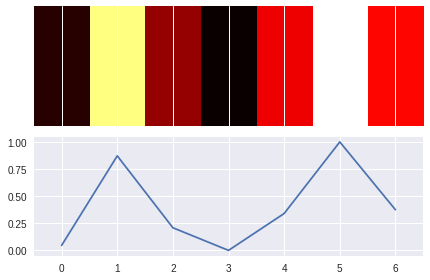

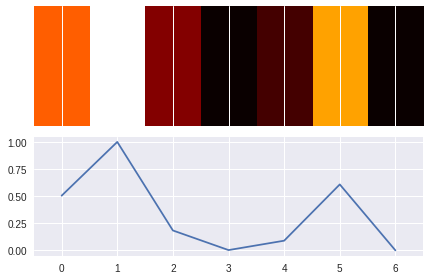

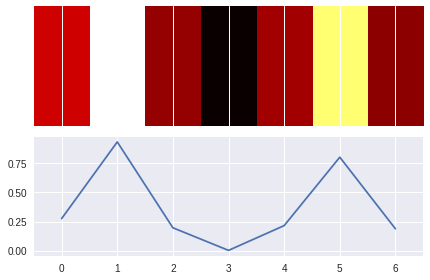

In [0]:
seq_len = len(xs[25][xs[25]>0])
cam_1 = normalize_cam(cam_1[-seq_len:])
cam_2 = normalize_cam(cam_2[-seq_len:])

print(' '.join([idx_to_word[idx] for idx in xs[25][xs[25]>0]]))
print(f'with label {ys[25].item()}')
print(f'with prediction prob. {torch.sigmoid(model(torch.tensor(xs[25:27]).cuda())).cpu().detach().numpy()[0][0]}')
plot_cam(list(range(seq_len)), cam_1)
plot_cam(list(range(seq_len)), cam_2)
plot_cam(list(range(seq_len)), (cam_1+cam_2)/2)

In [0]:
features = extract_features(torch.tensor(xs[70]).unsqueeze(0), model)
features_rnn = features[-1]   # (1, T, 2*H)
cam_1, cam_2 = return_cam(np.squeeze(features_rnn), np.squeeze(final_weights))

why did the pope say that " muslims are a curse to this world " ?
with label 1.0
with prediction prob. 0.6930760145187378


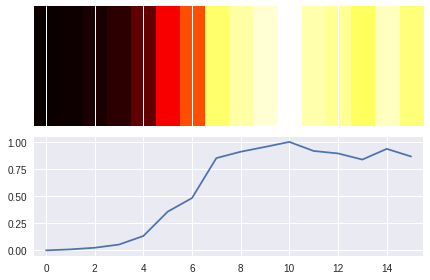

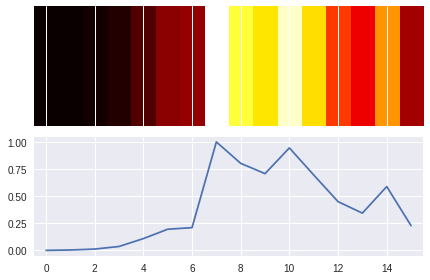

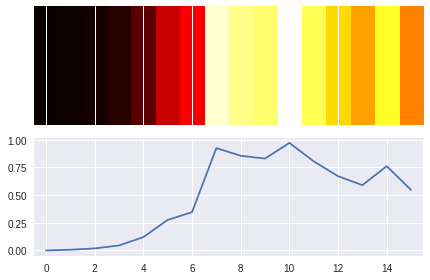

In [0]:
seq_len = len(xs[88][xs[88]>0])
cam_1 = normalize_cam(cam_1[-seq_len:])
cam_2 = normalize_cam(cam_2[-seq_len:])

print(' '.join([idx_to_word[idx] for idx in xs[88][xs[88]>0]]))
print(f'with label {ys[88].item()}')
print(f'with prediction prob. {torch.sigmoid(model(torch.tensor(xs[88:90]).cuda())).cpu().detach().numpy()[0][0]}')
plot_cam(list(range(seq_len)), cam_1)
plot_cam(list(range(seq_len)), cam_2)
plot_cam(list(range(seq_len)), (cam_1+cam_2)/2)

In [0]:
features = extract_features(torch.tensor(xs[196]).unsqueeze(0), model)
features_rnn = features[-1]   # (1, T, 2*H)
cam_1, cam_2 = return_cam(np.squeeze(features_rnn), np.squeeze(final_weights))

what is the average iq of people who don ' t believe in the flat earth ?
with label 1.0
with prediction prob. 0.6412089467048645


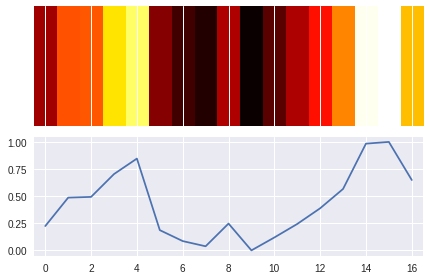

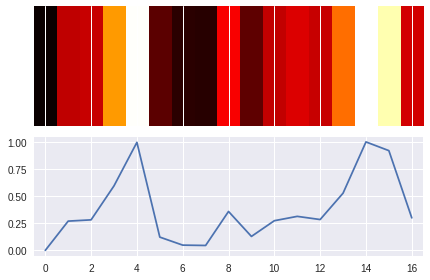

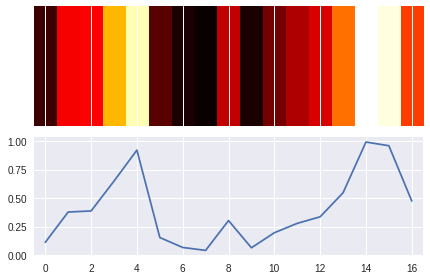

In [0]:
seq_len = len(xs[196][xs[196]>0])
cam_1 = normalize_cam(cam_1[-seq_len:])
cam_2 = normalize_cam(cam_2[-seq_len:])

print(' '.join([idx_to_word[idx] for idx in xs[196][xs[196]>0]]))
print(f'with label {ys[196].item()}')
print(f'with prediction prob. {torch.sigmoid(model(torch.tensor(xs[196:198]).cuda())).cpu().detach().numpy()[0][0]}')
plot_cam(list(range(seq_len)), cam_1)
plot_cam(list(range(seq_len)), cam_2)
plot_cam(list(range(seq_len)), (cam_1+cam_2)/2)

### Train normally

In [0]:
%%time
# bsz = 512, Adam with lr 1e-3, glove only
solver.train(loaders=(train_loader, val_loader), epochs=5)


Epoch 1 / 5:


For train set,
Best threshold is 0.2900, with F1 score: 0.6524
For val set,
Best threshold is 0.2500, with F1 score: 0.6484
{"metric": "F1", "value": 0.6524, "epoch": 1}
{"metric": "Val. F1", "value": 0.6484, "epoch": 1}
{"metric": "Loss", "value": 0.1232, "epoch": 1}
{"metric": "Val. Loss", "value": 0.1073, "epoch": 1}


Epoch 2 / 5:


For train set,
Best threshold is 0.3300, with F1 score: 0.6880
For val set,
Best threshold is 0.2900, with F1 score: 0.6609
{"metric": "F1", "value": 0.6880, "epoch": 2}
{"metric": "Val. F1", "value": 0.6609, "epoch": 2}
{"metric": "Loss", "value": 0.1068, "epoch": 2}
{"metric": "Val. Loss", "value": 0.1027, "epoch": 2}
updating best val f1...
updating best val loss...


Epoch 3 / 5:


For train set,
Best threshold is 0.2700, with F1 score: 0.7147
For val set,
Best threshold is 0.2900, with F1 score: 0.6708
{"metric": "F1", "value": 0.7147, "epoch": 3}
{"metric": "Val. F1", "value": 0.6708, "epoch": 3}
{"metric": "Loss", "value": 0.1018, "epoch": 3}
{"metric": "Val. Loss", "value": 0.1013, "epoch": 3}
updating best val f1...
updating best val loss...


Epoch 4 / 5:


For train set,
Best threshold is 0.3100, with F1 score: 0.7137
For val set,
Best threshold is 0.3300, with F1 score: 0.6757
{"metric": "F1", "value": 0.7137, "epoch": 4}
{"metric": "Val. F1", "value": 0.6757, "epoch": 4}
{"metric": "Loss", "value": 0.0981, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0987, "epoch": 4}
updating best val f1...
updating best val loss...


Epoch 5 / 5:


For train set,
Best threshold is 0.4100, with F1 score: 0.7236
For val set,
Best threshold is 0.3500, with F1 score: 0.6774
{"metric": "F1", "value": 0.7236, "epoch": 5}
{"metric": "Val. F1", "value": 0.6774, "epoch": 5}
{"metric": "Loss", "value": 0.0951, "epoch": 5}
{"metric": "Val. Loss", "value": 0.0986, "epoch": 5}
updating best val f1...
updating best val loss...

CPU times: user 8min 24s, sys: 2min 19s, total: 10min 44s
Wall time: 10min 56s


In [0]:
%%time
# bsz = 512, Adam with lr 1e-3, glove+para
solver.train(loaders=(train_loader, val_loader), epochs=5)


Epoch 1 / 5:


For train set,
Best threshold is 0.3000, with F1 score: 0.6625
For val set,
Best threshold is 0.3000, with F1 score: 0.6511
{"metric": "F1", "value": 0.6625, "epoch": 1}
{"metric": "Val. F1", "value": 0.6511, "epoch": 1}
{"metric": "Loss", "value": 0.1219, "epoch": 1}
{"metric": "Val. Loss", "value": 0.1062, "epoch": 1}


Epoch 2 / 5:


For train set,
Best threshold is 0.3200, with F1 score: 0.6913
For val set,
Best threshold is 0.3100, with F1 score: 0.6680
{"metric": "F1", "value": 0.6913, "epoch": 2}
{"metric": "Val. F1", "value": 0.6680, "epoch": 2}
{"metric": "Loss", "value": 0.1054, "epoch": 2}
{"metric": "Val. Loss", "value": 0.1011, "epoch": 2}
updating best val f1...
updating best val loss...


Epoch 3 / 5:


For train set,
Best threshold is 0.3500, with F1 score: 0.7153
For val set,
Best threshold is 0.3500, with F1 score: 0.6735
{"metric": "F1", "value": 0.7153, "epoch": 3}
{"metric": "Val. F1", "value": 0.6735, "epoch": 3}
{"metric": "Loss", "value": 0.0993, "epoch": 3}
{"metric": "Val. Loss", "value": 0.0997, "epoch": 3}
updating best val f1...
updating best val loss...


Epoch 4 / 5:


For train set,
Best threshold is 0.3800, with F1 score: 0.7348
For val set,
Best threshold is 0.3400, with F1 score: 0.6773
{"metric": "F1", "value": 0.7348, "epoch": 4}
{"metric": "Val. F1", "value": 0.6773, "epoch": 4}
{"metric": "Loss", "value": 0.0944, "epoch": 4}
{"metric": "Val. Loss", "value": 0.0984, "epoch": 4}
updating best val f1...
updating best val loss...


Epoch 5 / 5:


For train set,
Best threshold is 0.3400, with F1 score: 0.7651
For val set,
Best threshold is 0.3100, with F1 score: 0.6771
{"metric": "F1", "value": 0.7651, "epoch": 5}
{"metric": "Val. F1", "value": 0.6771, "epoch": 5}
{"metric": "Loss", "value": 0.0898, "epoch": 5}
{"metric": "Val. Loss", "value": 0.0987, "epoch": 5}

CPU times: user 11min 53s, sys: 5min 29s, total: 17min 22s
Wall time: 17min 40s


### Train normally (finetuning)

In [0]:
%%time
# bsz = 512, Adam with lr 1e-3
solver.train(loaders=(train_loader, val_loader), epochs=3)


Epoch 1 / 3:
t = 1000, loss = 0.1526
t = 2000, loss = 0.1433
For train set,
Best threshold is 0.3500, with F1 score: 0.6622
For val set,
Best threshold is 0.3200, with F1 score: 0.6465
{"metric": "F1", "value": 0.6622, "epoch": 1}
{"metric": "Val. F1", "value": 0.6465, "epoch": 1}
{"metric": "Loss", "value": 0.1231, "epoch": 1}
{"metric": "Val. Loss", "value": 0.1086, "epoch": 1}


Epoch 2 / 3:
t = 1000, loss = 0.0915
t = 2000, loss = 0.1176
For train set,
Best threshold is 0.2700, with F1 score: 0.6885
For val set,
Best threshold is 0.3200, with F1 score: 0.6627
{"metric": "F1", "value": 0.6885, "epoch": 2}
{"metric": "Val. F1", "value": 0.6627, "epoch": 2}
{"metric": "Loss", "value": 0.1071, "epoch": 2}
{"metric": "Val. Loss", "value": 0.1043, "epoch": 2}
updating best val f1...
updating best val loss...


Epoch 3 / 3:
t = 1000, loss = 0.0904
t = 2000, loss = 0.1077
For train set,
Best threshold is 0.2700, with F1 score: 0.6973
For val set,
Best threshold is 0.2800, with F1 score: 0

In [0]:
for param_group in solver.optimizer.param_groups:
    param_group['lr'] = 1e-4
solver.model.emb.weight.requires_grad = True
solver.optimizer.add_param_group({'params': solver.model.emb.parameters(), 'lr':5e-5})

In [0]:
%%time
# bsz = 512, Adam with lr 1e-3, no spell correction, xavier uniform
# glove embedding, WITH finetuning
solver.train(loaders=(train_loader, val_loader), epochs=2)


Epoch 1 / 2:
t = 1000, loss = 0.0993
t = 2000, loss = 0.0914
For train set,
Best threshold is 0.2900, with F1 score: 0.7165
For val set,
Best threshold is 0.3100, with F1 score: 0.6777
{"metric": "F1", "value": 0.7165, "epoch": 1}
{"metric": "Val. F1", "value": 0.6777, "epoch": 1}
{"metric": "Loss", "value": 0.0992, "epoch": 1}
{"metric": "Val. Loss", "value": 0.0999, "epoch": 1}


Epoch 2 / 2:
t = 1000, loss = 0.1152
t = 2000, loss = 0.1123
For train set,
Best threshold is 0.3500, with F1 score: 0.7278
For val set,
Best threshold is 0.3500, with F1 score: 0.6810
{"metric": "F1", "value": 0.7278, "epoch": 2}
{"metric": "Val. F1", "value": 0.6810, "epoch": 2}
{"metric": "Loss", "value": 0.0954, "epoch": 2}
{"metric": "Val. Loss", "value": 0.0986, "epoch": 2}
updating best val f1...
updating best val loss...

CPU times: user 4min 20s, sys: 2min 14s, total: 6min 35s
Wall time: 6min 36s


## Some testing stuffs

In [0]:
seq = torch.rand(3, 5, 6)

In [0]:
seq

tensor([[[0.9290, 0.3110, 0.1748, 0.4203, 0.9563, 0.7663],
         [0.1402, 0.7944, 0.6214, 0.4870, 0.8681, 0.9936],
         [0.8265, 0.5991, 0.5629, 0.9849, 0.7931, 0.1329],
         [0.7366, 0.8307, 0.5090, 0.9726, 0.8776, 0.0852],
         [0.4223, 0.8344, 0.7396, 0.6959, 0.0911, 0.2072]],

        [[0.2531, 0.7484, 0.5101, 0.2923, 0.1277, 0.3228],
         [0.4745, 0.3528, 0.6603, 0.3352, 0.7417, 0.1111],
         [0.0655, 0.9900, 0.3369, 0.5852, 0.3814, 0.7726],
         [0.5851, 0.6674, 0.8481, 0.8356, 0.9766, 0.5124],
         [0.3095, 0.4030, 0.8293, 0.1268, 0.0119, 0.1254]],

        [[0.7412, 0.4368, 0.4634, 0.6632, 0.2214, 0.1077],
         [0.3591, 0.9070, 0.5333, 0.9486, 0.2246, 0.8948],
         [0.5944, 0.8025, 0.0369, 0.2078, 0.4784, 0.9343],
         [0.6325, 0.7201, 0.0148, 0.1840, 0.3342, 0.1969],
         [0.2734, 0.5416, 0.6836, 0.3376, 0.3794, 0.3224]]])

In [0]:
torch.max(seq, 1)

(tensor([[0.9290, 0.8344, 0.7396, 0.9849, 0.9563, 0.9936],
         [0.5851, 0.9900, 0.8481, 0.8356, 0.9766, 0.7726],
         [0.7412, 0.9070, 0.6836, 0.9486, 0.4784, 0.9343]]),
 tensor([[0, 4, 4, 2, 0, 1],
         [3, 2, 3, 3, 3, 2],
         [0, 1, 4, 1, 2, 2]]))

In [0]:
drop = nn.Dropout2d(0.5)
drop_ = nn.Dropout(0.5)

In [0]:
drop(seq.transpose(1,2).unsqueeze(-1)).squeeze().transpose(1,2)

tensor([[[1.8579, 0.0000, 0.3497, 0.8406, 1.9125, 0.0000],
         [0.2804, 0.0000, 1.2427, 0.9740, 1.7361, 0.0000],
         [1.6530, 0.0000, 1.1259, 1.9699, 1.5861, 0.0000],
         [1.4732, 0.0000, 1.0179, 1.9451, 1.7552, 0.0000],
         [0.8447, 0.0000, 1.4791, 1.3918, 0.1823, 0.0000]],

        [[0.5063, 1.4969, 1.0202, 0.0000, 0.0000, 0.0000],
         [0.9489, 0.7055, 1.3206, 0.0000, 0.0000, 0.0000],
         [0.1310, 1.9800, 0.6738, 0.0000, 0.0000, 0.0000],
         [1.1703, 1.3348, 1.6962, 0.0000, 0.0000, 0.0000],
         [0.6191, 0.8059, 1.6585, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.8735, 0.9268, 0.0000, 0.0000, 0.2153],
         [0.0000, 1.8140, 1.0666, 0.0000, 0.0000, 1.7897],
         [0.0000, 1.6050, 0.0738, 0.0000, 0.0000, 1.8687],
         [0.0000, 1.4402, 0.0296, 0.0000, 0.0000, 0.3938],
         [0.0000, 1.0831, 1.3672, 0.0000, 0.0000, 0.6447]]])

In [0]:
drop_(seq)

tensor([[[1.8579, 0.0000, 0.0000, 0.0000, 1.9125, 1.5326],
         [0.0000, 1.5888, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.1982, 0.0000, 0.0000, 0.0000, 0.2659],
         [1.4732, 1.6613, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.4791, 0.0000, 0.1823, 0.4144]],

        [[0.0000, 1.4969, 1.0202, 0.5847, 0.0000, 0.6456],
         [0.0000, 0.7055, 0.0000, 0.0000, 1.4834, 0.0000],
         [0.0000, 0.0000, 0.6738, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.6962, 0.0000, 1.9532, 0.0000],
         [0.0000, 0.8059, 1.6585, 0.2536, 0.0238, 0.2509]],

        [[1.4824, 0.8735, 0.9268, 0.0000, 0.0000, 0.0000],
         [0.0000, 1.8140, 1.0666, 1.8971, 0.4491, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.9568, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.3680, 0.6684, 0.0000],
         [0.5468, 1.0831, 1.3672, 0.6752, 0.0000, 0.0000]]])

In [0]:
y_true = np.array([1,0,0,1,0,0,0,0,0,1])
pred = np.array([.95,0.1,0.03,0.21,0.102,0.05,0.34,0.15,.87,.90])

In [0]:
def f1_threshold(y_true, preds):
    best_f1 = 0
    for i in np.arange(0.1, 0.51, 0.01):
        f1 = f1_score(y_true, preds>=i)
        if f1 > best_f1:
            threshold = i
            best_f1 = f1
    return best_f1, threshold

f1_threshold(y_true, pred)

(0.7499999999999999, 0.15999999999999998)

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve
def f1_threshold(y_true, preds):
    precision, recall, thresholds = precision_recall_curve(y_true, preds)
    thresholds = np.append(thresholds, 1.001)
    F = 2*precision*recall / (precision + recall)
    best_f1 = np.max(F)
    threshold = thresholds[np.argmax(F)]
    return best_f1, threshold

f1_threshold(y_true, pred)

(0.8, 0.9)

In [0]:
precision, recall, thresholds = precision_recall_curve(y_true, pred)

In [0]:
thresholds = np.append(thresholds, 1.001)

In [0]:
thresholds

array([0.21 , 0.34 , 0.87 , 0.9  , 0.95 , 1.001])

In [0]:
recall

array([1.        , 0.66666667, 0.66666667, 0.66666667, 0.33333333,
       0.        ])

In [0]:
precision

array([0.6       , 0.5       , 0.66666667, 1.        , 1.        ,
       1.        ])

In [0]:
f1 = 2*precision*recall / (precision + recall)

In [0]:
f1

array([0.75      , 0.57142857, 0.66666667, 0.8       , 0.5       ,
       0.        ])

In [0]:
np.max(f1), thresholds[np.argmax(f1)]

(0.8, 0.9)

In [0]:
solver.check_f1(val_loader)

Best threshold is 0.3456, with F1 score: 0.6853


(0.6853118712273641, 0.3456084728240967, 0.09613535019989107)

In [0]:
solver.check_f1(val_loader)

Best threshold is 0.3500, with F1 score: 0.6850


(0.6849844308614923, 0.34999999999999987, 0.09613535019989107)